In [ ]:
# Declare dependencies
import requests
import pandas as pd
import json
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display, clear_output
import hvplot.pandas
import os
import csv  
import time 
import numpy as np
import scipy.stats as st
import logging
import plotly.express as px
import ipywidgets as widgets
import seaborn as sns

# Import api keys
from api_key import weather_api_key 

In [ ]:
# API details
API_KEY = weather_api_key
AIR_POLLUTION_URL = "http://api.openweathermap.org/data/2.5/air_pollution"

# Function to fetch air pollution data
def fetch_air_pollution(lat, lon):
    url = f"http://api.openweathermap.org/data/2.5/air_pollution?lat={lat}&lon={lon}&appid={API_KEY}"
    response = requests.get(url)
    
    if response.status_code == 200:
        data = response.json()
        
        # Extract pollutants
        pollution_data = data['list'][0]['components']
        
        # Return a dictionary with pollutant values
        return {
            "SO2": pollution_data.get("so2", None),
            "NO2": pollution_data.get("no2", None),
            "PM10": pollution_data.get("pm10", None),
            "PM2.5": pollution_data.get("pm2_5", None),
            "O3": pollution_data.get("o3", None),
            "CO": pollution_data.get("co", None)
        }
    else:
        print(f"Failed to fetch data for {lat}, {lon}: {response.status_code}")
        return None

# Load the existing CSV file
csv_file = "resources/csv 2.0.csv"  # Replace with your actual CSV filename
df = pd.read_csv(csv_file)

# Create empty lists to store pollution data
so2_list, no2_list, pm10_list, pm25_list, o3_list, co_list = [], [], [], [], [], []

# Fetch air pollution data for each row
for _, row in df.iterrows():
    lat, lon = row['Latitude'], row['Longitude']
    pollution = fetch_air_pollution(lat, lon)
    
    if pollution:
        so2_list.append(pollution["SO2"])
        no2_list.append(pollution["NO2"])
        pm10_list.append(pollution["PM10"])
        pm25_list.append(pollution["PM2.5"])
        o3_list.append(pollution["O3"])
        co_list.append(pollution["CO"])
    else:
        so2_list.append(None)
        no2_list.append(None)
        pm10_list.append(None)
        pm25_list.append(None)
        o3_list.append(None)
        co_list.append(None)

# Append new columns to the DataFrame
df["SO2"] = so2_list
df["NO2"] = no2_list
df["PM10"] = pm10_list
df["PM2.5"] = pm25_list
df["O3"] = o3_list
df["CO"] = co_list

# Save the updated DataFrame back to CSV
updated_csv_file = "updated_data.csv"
df.to_csv(updated_csv_file, index=False)

# Display the updated DataFrame
df.head()

print(f"Updated CSV saved as {'CSV 2.0'}")


Updated CSV saved as CSV 2.0


In [14]:
# Load the CSV file created in Part 1 into a Pandas DataFrame
# The csv has data of the top 1,000 most populated cities in the world
city_data_df = pd.read_csv("resources/csv 2.0.csv")

# Display sample data - first ten rows
city_data_df.head(10)

,rank,Latitude,Longitude,Name of City,Country,2021 Population,2020 Population,Growth,Population Difference,Population Change,SO2,NO2,PM10,PM2.5,O3,CO
0,1,35.682839,139.759455,Tokyo,Japan,37339804,37393128,-0.0014,53324,declined,10.97,20.74,2.16,1.23,56.51,360.49
1,2,28.651718,77.221939,Delhi,India,31181376,30290936,0.0294,890440,grew,18.12,18.85,116.15,93.09,95.84,814.44
2,3,31.232276,121.469207,Shanghai,China,27795702,27058480,0.0272,737222,grew,43.39,34.96,34.58,16.99,45.42,423.91
3,4,-23.550651,-46.633382,Sao Paulo,Brazil,22237472,22043028,0.0088,194444,grew,35.29,19.02,89.64,75.22,286.10,974.66
4,5,19.432630,-99.133178,Mexico City,Mexico,21918936,21782378,0.0063,136558,grew,74.39,45.93,67.52,59.80,181.68,1174.93
5,6,23.786198,90.402615,Dhaka,Bangladesh,21741090,21005860,0.0350,735230,grew,9.30,73.34,289.18,230.89,1.77,2723.69
6,7,30.044388,31.235726,Cairo,Egypt,21322750,20900604,0.0202,422146,grew,24.80,13.02,10.30,4.16,67.95,283.72
7,8,39.906217,116.391276,Beijing,China,20896820,20462610,0.0212,434210,grew,32.90,31.19,48.98,20.98,56.51,413.90
8,9,19.075990,72.877393,Mumbai,India,20667656,20411274,0.0126,256382,grew,71.53,90.48,381.68,280.37,31.47,3070.83
9,10,34.619881,135.490357,Osaka,Japan,19110616,19165340,-0.0029,54724,declined,2.83,5.48,1.03,0.50,88.69,263.69


In [15]:
# Print all the columns in the dataframe to verify full dataset
print(city_data_df.columns)

Index(['rank', 'Latitude', 'Longitude', 'Name of City', 'Country',
       '2021 Population', '2020 Population', 'Growth', 'Population Difference',
       'Population Change', 'SO2', 'NO2', 'PM10', 'PM2.5', 'O3', 'CO'],
      dtype='object')


In [16]:
# Using the .rename function, Rename columns to match expected names
# Renaming "Name of City" to "City" and "2021 Population" to "Population"
# The inplace=True parameter modifies the DataFrame directly instead of creating a new one.
city_data_df.rename(columns={"Name of City": "City", "2021 Population": "Population"}, inplace=True)

# Create dictionaries to store top 100 most and least polluted cities per pollutant
# These will be used to store the 100 most polluted and 100 least polluted cities for each pollutant.
top_polluted_cities = {}
least_polluted_cities = {}

# Use a for loop to loop to iterate through a list of pollutants that are present in the dataset: "SO2", "NO2", "PM10", "PM2.5", "O3", "CO".
# Each iteration processes one pollutant at a time.
for pollutant in ["SO2", "NO2", "PM10", "PM2.5", "O3", "CO"]:
    if pollutant in city_data_df.columns:  # Before processing, the code checks whether the current pollutant exists as a column in city_data_df to prevent errors.
        # city_data_df.nlargest(100, pollutant) selects the 100 rows with the highest values for the given pollutant.
        top_polluted_cities[pollutant] = city_data_df.nlargest(100, pollutant)[["City", "Country", "Population", pollutant]]

        # city_data_df.nsmallest(100, pollutant) selects the 100 rows with the lowest values for the given pollutant.
        least_polluted_cities[pollutant] = city_data_df.nsmallest(100, pollutant)[["City", "Country", "Population", pollutant]]
        # Each result is stored in the corresponding dictionary (top_polluted_cities or least_polluted_cities) using the pollutant name as the key.
        # The [['City', 'Population', pollutant]] part ensures only these three columns are kept.
    else:
        print(f"Warning: Column '{pollutant}' not found in DataFrame.")
        # If a pollutant column is missing, the script prints a warning message instead of throwing an error.

In [17]:
# Rename columns for clarity
city_data_df.rename(columns={"Name of City": "City", "2021 Population": "Population"}, inplace=True)

# Available pollutants
pollutants = ["SO2", "NO2", "PM10", "PM2.5", "O3", "CO"]

# Dropdown widget to select pollutant
pollutant_dropdown = widgets.Dropdown(
    options=pollutants,
    value="SO2",
    description="Select Pollutant:",
    style={"description_width": "initial"}
)

# Create output widget
output = widgets.Output()

def update_scatter_plot(change):
    with output:
        clear_output(wait=True)
        selected_pollutant = change["new"]  # Get the newly selected pollutant
        fig = px.scatter(
            city_data_df,
            x="Population",
            y=selected_pollutant,
            hover_data={"City": True, "Country": True, "Population": ':,', selected_pollutant: ':,.2f'},
            labels={"Population": "Population (millions)", selected_pollutant: f"{selected_pollutant} Level"},
            title=f"Pollution Levels vs Population ({selected_pollutant})",
        )
        display(fig)

# Display dropdown and interactive scatter plot
display(pollutant_dropdown, output)

# Observe changes in dropdown selection
pollutant_dropdown.observe(update_scatter_plot, names="value")

# Initial plot
with output:
    update_scatter_plot({"new": pollutant_dropdown.value})  # Pass initial value correctly


Dropdown(description='Select Pollutant:', options=('SO2', 'NO2', 'PM10', 'PM2.5', 'O3', 'CO'), style=Descripti…

Output()

In [18]:
# Dropdown widget to select pollutant
pollutant_dropdown = widgets.Dropdown(
    options=pollutants,
    value="SO2",
    description="Select Pollutant:",
    style={"description_width": "initial"}
)

# Function to update interactive bar chart
def update_bar_chart(pollutant):
    top_cities = city_data_df.nlargest(10, pollutant)[["City", "Country", "Population", pollutant]].copy()
    top_cities["City_Country"] = top_cities["City"] + ", " + top_cities["Country"]
    
    # Format population with commas
    top_cities["Population"] = top_cities["Population"].apply(lambda x: f"{x:,.0f}")  # Adds commas to large numbers

    # Create interactive bar chart with hover text
    fig = px.bar(
        top_cities,
        x=pollutant,
        y="City_Country",
        orientation='h',
        text=top_cities[pollutant].round(2),  # Show pollution value on bars
        hover_data={"Population": True, pollutant: True, "City_Country": False},  # Display extra details on hover
        labels={pollutant: "Pollution Level", "City_Country": "City, Country", "Population": "Population"},
        title=f"Top 10 Most Polluted Cities by {pollutant}"
    )

    fig.update_traces(textposition="outside")  # Position text labels
    fig.update_layout(yaxis=dict(autorange="reversed"))  # Reverse Y-axis to match bar order

    fig.show()

# Display dropdown and interactive bar chart
display(pollutant_dropdown)
widgets.interactive(update_bar_chart, pollutant=pollutant_dropdown)

Dropdown(description='Select Pollutant:', options=('SO2', 'NO2', 'PM10', 'PM2.5', 'O3', 'CO'), style=Descripti…

interactive(children=(Dropdown(description='Select Pollutant:', options=('SO2', 'NO2', 'PM10', 'PM2.5', 'O3', …

In [19]:
# Dropdown widget to select pollutant
pollutant_dropdown = widgets.Dropdown(
    options=pollutants,
    value="SO2",
    description="Select Pollutant:",
    style={"description_width": "initial"}
)

# Function to update interactive bar chart
def update_bar_chart(pollutant):
    top_cities = city_data_df.nsmallest(10, pollutant)[["City", "Country", "Population", pollutant]].copy()
    top_cities["City_Country"] = top_cities["City"] + ", " + top_cities["Country"]
    
    # Format population with commas
    top_cities["Population"] = top_cities["Population"].apply(lambda x: f"{x:,.0f}")  # Adds commas to large numbers

    # Create interactive bar chart with hover text
    fig = px.bar(
        top_cities,
        x=pollutant,
        y="City_Country",
        orientation='h',
        text=top_cities[pollutant].round(2),  # Show pollution value on bars
        hover_data={"Population": True, pollutant: True, "City_Country": False},  # Display extra details on hover
        labels={pollutant: "Pollution Level", "City_Country": "City, Country", "Population": "Population"},
        title=f"Top 10 Least Polluted Cities by {pollutant}"
    )

    fig.update_traces(textposition="outside")  # Position text labels
    fig.update_layout(yaxis=dict(autorange="reversed"))  # Reverse Y-axis to match bar order

    fig.show()

# Display dropdown and interactive bar chart
display(pollutant_dropdown)
widgets.interactive(update_bar_chart, pollutant=pollutant_dropdown)

Dropdown(description='Select Pollutant:', options=('SO2', 'NO2', 'PM10', 'PM2.5', 'O3', 'CO'), style=Descripti…

interactive(children=(Dropdown(description='Select Pollutant:', options=('SO2', 'NO2', 'PM10', 'PM2.5', 'O3', …

In [20]:

fig = px.scatter_map( # This function generates a scatter plot on an interactive map.
   city_data_df, # The DataFrame containing city pollution data.
    lat="Latitude", # Specifies the Latitude column for positioning points on the map.
    lon="Longitude", # Specifies the Longitude column for positioning points on the map.
    hover_name="City", # When you hover over a point, the city name is displayed as the main label.
    hover_data={ # Defines additional data to show when hovering over a city
        "Country": True,
        "Population": True,
        "SO2": True,            # Display the hotel name in the hover tooltip
        "NO2": True,
        "PM10": True,   
        "PM2.5": True, 
        "O3": True, 
        "CO": True,       
        "Latitude": False,                  # Optionally hide columns you don't need in the hover
        "Longitude": False
    },
    zoom=1.5,
    height=700,
    title="City Pollution by Population"
)

# Use an open source map style
fig.update_layout(mapbox_style="open-street-map")



In [21]:
# Dropdown widget to select pollutant
pollutant_dropdown = widgets.Dropdown(
    options=pollutants,
    value="SO2",  # Default value
    description="Pollutant:",
    style={'description_width': 'initial'}
)

# Function to update and display the heatmap
def update_heatmap(pollutant):
    fig = px.density_mapbox(
        city_data_df,  # Calls in our dataframe
        lat="Latitude",
        lon="Longitude",
        z=pollutant,  # The column representing pollution levels
        radius=15,  # Adjust radius for density effect
        hover_name="City",  # Show city name on hover
        hover_data={"Country": True, "Population": True, pollutant: True, "Latitude": False, "Longitude": False},
        mapbox_style="open-street-map",  # Free OpenStreetMap style
        zoom=1.5,  # Adjust zoom level for global view
        height=700,
        title=f"Global Heatmap of {pollutant} Pollution Levels"
    )
    fig.show()

# Create an interactive output display
widgets.interactive(update_heatmap, pollutant=pollutant_dropdown)


interactive(children=(Dropdown(description='Pollutant:', options=('SO2', 'NO2', 'PM10', 'PM2.5', 'O3', 'CO'), …

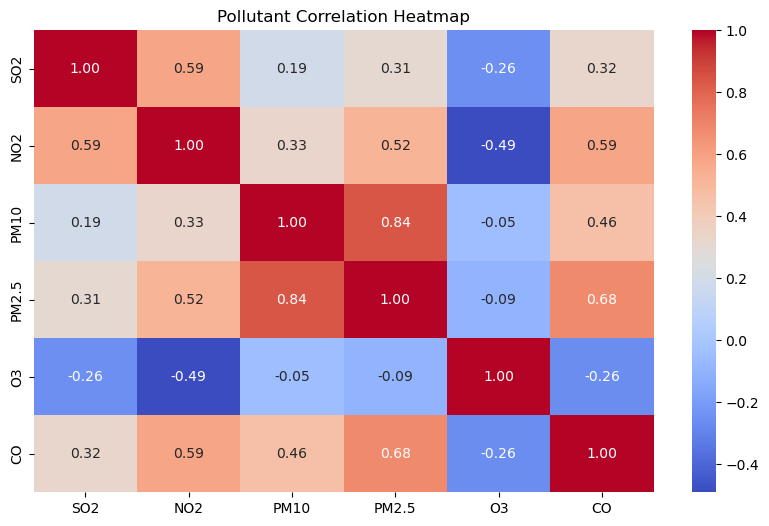

In [22]:

# Calculate correlation matrix
correlation_matrix = city_data_df[["SO2", "NO2", "PM10", "PM2.5", "O3", "CO"]].corr()

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Pollutant Correlation Heatmap")
plt.show()

# Correlation Coefficients:

# The exact correlation coefficient (between -1 and 1) will be annotated in each square.
# 1: Perfect positive correlation (both pollutants behave in the exact same way).
# 0: No correlation (the two pollutants do not influence each other).
# -1: Perfect negative correlation (as one pollutant increases, the other decreases).
